# Assignment1

Remember -> submission using itslearning, both notebook and github repo *deadline on 22.11.2021*

### Updating environment

In [ ]:
#updating and restarting sklearn
!pip install --upgrade scikit-learn --quiet

In [ ]:
import sklearn
sklearn.__version__

In [ ]:
# First upgrade the environment.
import pip
from subprocess import run
# add what you will need
modules =[
    'xlrd',
    'matplotlib', 
    'numpy',
    'sklearn',
    'pandas',
    'zipfile36'
]
proc = run(f'pip install {" ".join(modules)} --upgrade --no-input', 
       shell=True, 
       text=True, 
       capture_output=True, 
       timeout=120) #a couple of minutes
print(proc.stderr)

## Collecting and importing needed libraries

In [1]:
#Importing needed libraries
import zipfile
import pandas as pd
import numpy as np
from pandas import set_option

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression, Lasso, ElasticNet
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)

# Task 1 (3 points):

Regression $\to$ Superconductivity Data Set

The goal here is to predict the critical temperature based on the features extracted.

https://archive.ics.uci.edu/ml/datasets/Superconductivty+Data

* Fit two regression models to predict the critical temperature. Report the score with the default parameters of each model.
* Perform a simple manual optimization for one of the default parameters (at least 5 different values) and plot the new obtained score as a function of the chosen parameter. Plot the coefficient magnitudes for the best model. 

## Reading and loading data and creating the functions to be used to run models

In [2]:
#Reading and loading the data set for Task 1
import zipfile, requests, io
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00464/superconduct.zip'
file_name = 'train.csv'
data = pd.read_csv(zipfile.ZipFile(io.BytesIO(requests.get(url, stream=True).content)).open(file_name))

In [3]:
#Inspecting the data
set_option('precision', 2)
data.describe()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
count,21263.00,21263.00,21263.00,21263.00,21263.00,21263.00,21263.00,21263.00,21263.00,21263.00,...,21263.00,21263.00,21263.00,21263.00,21263.00,21263.00,21263.00,21263.00,21263.00,2.13e+04
mean,4.12,87.56,72.99,71.29,58.54,1.17,1.06,115.60,33.23,44.39,...,3.15,3.06,3.06,1.30,1.05,2.04,1.48,0.84,0.67,3.44e+01
std,1.44,29.68,33.49,31.03,36.65,0.36,0.40,54.63,26.97,20.04,...,1.19,1.05,1.17,0.39,0.38,1.24,0.98,0.48,0.46,3.43e+01
min,1.00,6.94,6.42,5.32,1.96,0.00,0.00,0.00,0.00,0.00,...,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,2.10e-04
25%,3.00,72.46,52.14,58.04,35.25,0.97,0.78,78.51,16.82,32.89,...,2.12,2.28,2.09,1.06,0.78,1.00,0.92,0.45,0.31,5.37e+00
50%,4.00,84.92,60.70,66.36,39.92,1.20,1.15,122.91,26.64,45.12,...,2.62,2.62,2.43,1.37,1.17,2.00,1.06,0.80,0.50,2.00e+01
75%,5.00,100.40,86.10,78.12,73.11,1.44,1.36,154.12,38.36,59.32,...,4.03,3.73,3.91,1.59,1.33,3.00,1.92,1.20,1.02,6.30e+01
max,9.00,208.98,208.98,208.98,208.98,1.98,1.96,207.97,205.59,101.02,...,7.00,7.00,7.00,2.14,1.95,6.00,6.99,3.00,3.00,1.85e+02


In [4]:
#Creating a function that splits the data into features and labels
def split_data (df, label_name):
    #Splitting data into features and labels
    features_X = df.loc[:, df.columns != label_name]
    labels_y = df[[label_name]].values.ravel()
    return features_X, labels_y

In [5]:
#Setting and splitting the data
data_ct = split_data(df=data, label_name='critical_temp')

In [6]:
#Creating a function that runs a model given a dataset, model and label_name
def run_regression (df, model, label_name, random_state):
    #Splitting data into train and test
    X_train, X_test, y_train, y_test = train_test_split(df[0], df[1], test_size = 0.2, random_state = random_state)
    #Running the model using the training set
    base_model = model
    base_model.fit(X_train, y_train)
    #Computing for accuracy scores
    training_score = base_model.score(X_train, y_train)
    test_score = base_model.score(X_test, y_test)
    #Creating function to print accuracy scores
    def print_scores():
        print("Accuracy scores for model:",model)
        print("Training set score: {:.3f}".format(training_score))
        print("Test set score: {:.3f}".format(test_score))
    return print_scores(), base_model, training_score, test_score

In [7]:
#Creating a function that runs a model given a dataset, model_name and label_name, featuresm Standard Scaler applied to data
def run_regression_scaled (df, model, label_name, random_state):
    #Splitting data into train and test
    X_train, X_test, y_train, y_test = train_test_split(df[0], df[1], test_size = 0.2, random_state = random_state)
    #Scale training and data
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    #Running the model using the training set
    base_model = model
    base_model.fit(X_train_scaled, y_train)
    #Computing for accuracy scores
    training_score = base_model.score(X_train_scaled, y_train)
    test_score = base_model.score(X_test_scaled, y_test)
    #Creating function to print accuracy scores
    def print_scores():
        print("Accuracy scores for model:",model)
        print("Training set score: {:.3f}".format(training_score))
        print("Test set score: {:.3f}".format(test_score))
    return print_scores(), base_model, training_score, test_score

In [8]:
#Creating function for plotting accuracy scores by values of parameter
def plot_accuracy(title,x_axis_name,y_axis_name,param,train_score,test_score):
    plt.figure(figsize=(12, 5))
    plt.plot(param, train_score, label="training accuracy",marker='o')
    plt.plot(param, test_score, label="test accuracy",marker='p')
    plt.title(title)
    plt.ylabel(y_axis_name)
    plt.xlabel(x_axis_name)
    plt.gca().invert_xaxis()
    plt.legend()

## Running two regression models using default parameters

In [9]:
#Running a Lasso regression model
run_regression_scaled(df=data_ct,model=Lasso(),label_name='critical_temp',random_state=7)

Accuracy scores for model: Lasso()
Training set score: 0.649
Test set score: 0.660


(None, Lasso(), 0.6487150648078479, 0.6596979439787765)

In [10]:
#Running an ElasticNet regression model
run_regression_scaled(df=data_ct,model=ElasticNet(),label_name='critical_temp',random_state=7)

Accuracy scores for model: ElasticNet()
Training set score: 0.623
Test set score: 0.635


(None, ElasticNet(), 0.6231964406488355, 0.6346651488359685)

Running the regression models using just default parameters resulted in having Lasso a slightly higher test score with 0.660 while ElasticNet produced a test score of 0.635.

## Running the models with manual optimization of parameters with at least 5 different values
Here we run different Lasso and ElasticNet models by optimizing the alpha parameter.

### Lasso Regression

#### Running Lasso regression models with different alpha values

In [11]:
#Setting different parameters of alpha for the Lasso regression
alpha_values_l = (0.1, 0.5, 2, 4, 6)
lnum = len(alpha_values_l)
pred_num = data_ct[0].shape[1]

In [12]:
coeff_a = np.zeros((lnum, pred_num))
train_r2 = np.zeros(lnum)
test_r2 = np.zeros(lnum)

for idx, l in enumerate(alpha_values_l):
    models = run_regression_scaled(data_ct, model=Lasso(alpha=l), label_name='critical_temp',random_state=7)
    
    coeff_a[idx, :] = models[1].coef_
    train_r2[idx] = models[2]
    test_r2[idx] = models[3]
    print("\n")

Accuracy scores for model: Lasso(alpha=0.1)
Training set score: 0.710
Test set score: 0.718


Accuracy scores for model: Lasso(alpha=0.5)
Training set score: 0.674
Test set score: 0.683


Accuracy scores for model: Lasso(alpha=2)
Training set score: 0.615
Test set score: 0.626


Accuracy scores for model: Lasso(alpha=4)
Training set score: 0.569
Test set score: 0.581


Accuracy scores for model: Lasso(alpha=6)
Training set score: 0.534
Test set score: 0.545




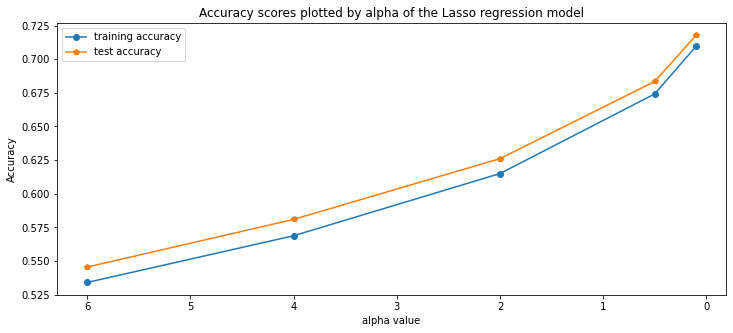

In [13]:
#Plotting accuracy scores of Lasso regression models by alpha values
plot_accuracy(title="Accuracy scores plotted by alpha of the Lasso regression model",x_axis_name="alpha value",y_axis_name="Accuracy",param=alpha_values_l,train_score=train_r2,test_score=test_r2)

In [14]:
#Running the best model
best_lasso = run_regression_scaled(df=data_ct,model=Lasso(alpha=0.5),label_name='critical_temp',random_state=7)

Accuracy scores for model: Lasso(alpha=0.5)
Training set score: 0.674
Test set score: 0.683


The best model for the Lasso regression according to the sweet spot of test accuracy scores is at alpha = 0.5 and the corresponding test accuracy score is 0.683 that is a slight improvement from the model using just default parameters (accuracy = 0.660).

### ElasticNet Regression

#### Running ElasticNet models with different alpha values

In [15]:
#Setting different parameters of alpha for the ElasticNet
alpha_values_en = [0.1, 0.5, 2, 4, 6]
#Initializing accuracy data
training_accuracy_en = []
test_accuracy_en = []
#Running the ElasticNet models
for value in alpha_values_en:
    dat = run_regression_scaled(data_ct, model=ElasticNet(alpha=value), label_name='critical_temp',random_state=7)
    #Recording training set accuracy
    training_accuracy_en.append(dat[2])
    #Recording test accuracy
    test_accuracy_en.append(dat[3])
    print("\n")

Accuracy scores for model: ElasticNet(alpha=0.1)
Training set score: 0.695
Test set score: 0.704


Accuracy scores for model: ElasticNet(alpha=0.5)
Training set score: 0.650
Test set score: 0.661


Accuracy scores for model: ElasticNet(alpha=2)
Training set score: 0.594
Test set score: 0.605


Accuracy scores for model: ElasticNet(alpha=4)
Training set score: 0.554
Test set score: 0.565


Accuracy scores for model: ElasticNet(alpha=6)
Training set score: 0.517
Test set score: 0.528




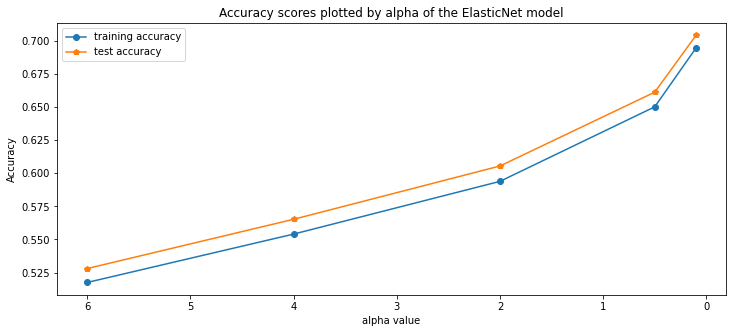

In [16]:
#Plotting accuracy scores of ElasticNet models by alpha values
plot_accuracy(title="Accuracy scores plotted by alpha of the ElasticNet model",x_axis_name="alpha value",y_axis_name="Accuracy",param=alpha_values_en,train_score=training_accuracy_en,test_score=test_accuracy_en)

In [17]:
#Running the best model
best_elasticnet = run_regression_scaled(df=data_ct,model=ElasticNet(alpha=0.5),label_name='critical_temp',random_state=7)


Accuracy scores for model: ElasticNet(alpha=0.5)
Training set score: 0.650
Test set score: 0.661


The best model for the ElasticRegression according to the sweet spot of test accuracy scores is at alpha = 0.5 with an accuracy score of 0.661 which is an improvement from the score of the model just using default parameters (0.635).

### Plotting the coefficient magnitudes of the two best models

In [18]:
X_names = list(data_ct[0].columns)

In [19]:
#Plotting the coefficient magnitude of the best model
def plot_coeff(model_l,model_en):
    plt.figure(figsize=(19, 5))
    plt.plot(model_l.coef_, '^', label=model_l)
    plt.plot(model_en.coef_, 's', label=model_en)
    plt.xticks(range(len(X_names)), X_names, rotation=90)
    plt.hlines(0, 0,len(X_names))
    plt.legend()
    #plt.legend(ncol=2, loc=(0, 0))
    #plt.ylim(-10, 5)
    plt.xlabel("Coefficient index")
    plt.ylabel("Coefficient magnitude")

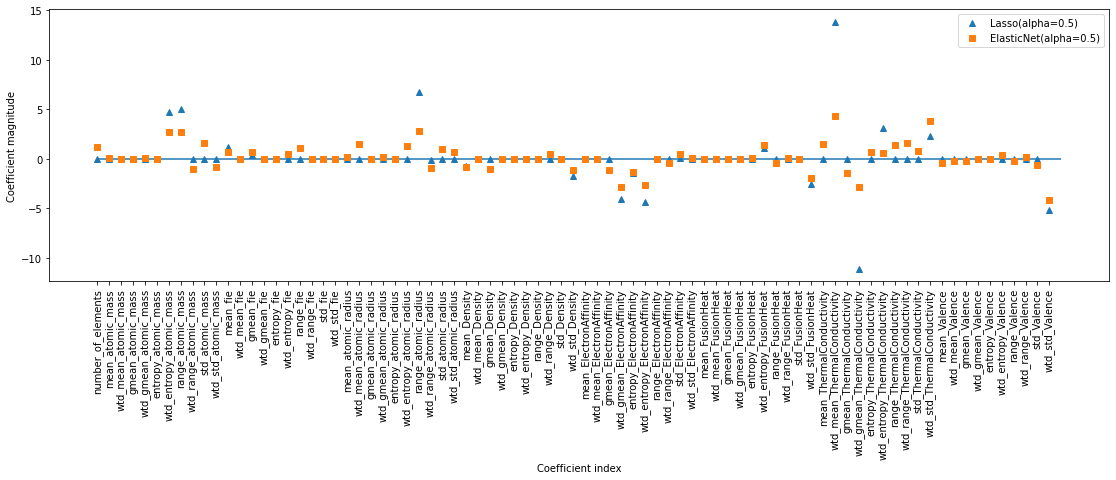

In [20]:
plot_coeff(best_lasso[1],best_elasticnet[1])

Here we see the regression coefficient values of the features for each of the best models - that is Lasso (alpha = 0.5) and ElasticNet(alpha=0.5) regression models.

# Task 2 (3 points):

Binary classification $\to$ Default of credit card clients Data Set

The goal here is to predict the default payment next month.

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

* Fit two binary classification models to predict the client's credit card default. Report accuracy with the default parameters of each model.
* Perform a simple manual optimization for one of the default parameters (at least 5 different values) and plot the new obtained accuracy as a function of the chosen parameter.. Plot the feature importance. 

<b>Predicting credit card default using two binary classification models</b>

For this task, we are to fit two binary classification models to predict the client's credit card default. Here we would be running a Logistic Regression and a Decision Tree Classification models.

## Reading and loading data and creating the functions to be used to run models

In [21]:
#Reading and loading the data set for Task 2
import zipfile, requests, io
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls'
data_2 = pd.read_excel(url, header=1, index_col=0)

In [22]:
#Creating a function that splits the data into features and labels
def split_data (df, label_name):
    #Splitting data into features and labels
    features_X = df.loc[:, df.columns != label_name]
    labels_y = df[[label_name]].values.ravel()
    return features_X, labels_y

In [23]:
#Setting and splitting the data
data_ccd = split_data(df=data_2, label_name='default payment next month')

In [28]:
#Creating a function that runs a model given a dataset, model and label_name
def run_model (df, model, label_name):
    #Splitting data into train and test
    X_train, X_test, y_train, y_test = train_test_split(df[0], df[1], test_size = 0.2, random_state = 11)
    #Running the model using the training set
    base_model = model
    base_model.fit(X_train.values, y_train)
    #Computing for accuracy scores
    training_score = base_model.score(X_train.values, y_train)
    test_score = base_model.score(X_test.values, y_test)
    #Creating function to print accuracy scores
    def print_scores():
        print("Accuracy scores for model:",model)
        print("Training set score: {:.3f}".format(training_score))
        print("Test set score: {:.3f}".format(test_score))
    return print_scores(), base_model, training_score, test_score

## Running binary classification models using default parameters

In [29]:
#Running a Decision Tree Classifier
run_model(df=data_ccd,model=DecisionTreeClassifier(),label_name='default payment next month')

Accuracy scores for model: DecisionTreeClassifier()
Training set score: 1.000
Test set score: 0.724


(None, DecisionTreeClassifier(), 0.9995, 0.7235)

In [30]:
#Running a Gradient Booster regression tree model
run_model(df=data_ccd,model=GradientBoostingClassifier(random_state=1),label_name='default payment next month')

Accuracy scores for model: GradientBoostingClassifier(random_state=1)
Training set score: 0.828
Test set score: 0.816


(None,
 GradientBoostingClassifier(random_state=1),
 0.8282083333333333,
 0.8161666666666667)

We see that the Decision Tree Classifier resulted to a very high training accuracy score (0.9995) which would suggest overfitting. The test accuracy score is good at 0.724.

The Gradient Booster Classifier model achieve a pretty good score in both the training (0.828) and test (0.816) data sets.

On the next step, we would manually optimize a parameter and see how that would affect the accuracy scores.

## Running the models with manual optimization of parameters with at least 5 different values
Here we run different Decision Trees and Gradient Boosted models by optimizing the max depth parameter

### Decision Tree Models

#### Running Decision Tree models with different max depth values

In [31]:
#Setting different parameters of max_depth for the Decision Trees
max_depth_values = [2,4,8,10,20]
#Initializing accuracy data
training_accuracy_data = []
test_accuracy_data = []
#Running the Decision Tree Classifier models
for value in max_depth_values:
    dat = run_model(df=data_ccd,model=DecisionTreeClassifier(max_depth= value),label_name='default payment next month')
    #Recording training set accuracy
    training_accuracy_data.append(dat[2])
    #Recording test accuracy
    test_accuracy_data.append(dat[3])
    print("\n")

Accuracy scores for model: DecisionTreeClassifier(max_depth=2)
Training set score: 0.821
Test set score: 0.814


Accuracy scores for model: DecisionTreeClassifier(max_depth=4)
Training set score: 0.825
Test set score: 0.815


Accuracy scores for model: DecisionTreeClassifier(max_depth=8)
Training set score: 0.837
Test set score: 0.812


Accuracy scores for model: DecisionTreeClassifier(max_depth=10)
Training set score: 0.849
Test set score: 0.807


Accuracy scores for model: DecisionTreeClassifier(max_depth=20)
Training set score: 0.943
Test set score: 0.759




#### Plotting accuracy scores of the Decision Tree models

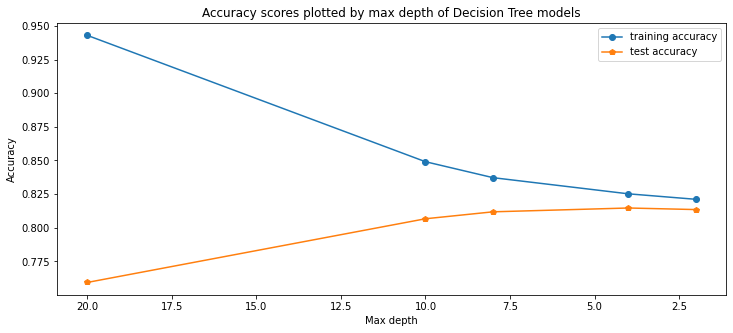

In [32]:
#Plotting accuracy scores of Decision Tree models by max depth values
plot_accuracy(title="Accuracy scores plotted by max depth of Decision Tree models",x_axis_name="Max depth",y_axis_name="Accuracy",param=max_depth_values,train_score=training_accuracy_data,test_score=test_accuracy_data)

Here we can see that optimizing (decreasing) the maximum depth of the tree resulted in seemingly solving the overfitting of the Decision Tree model using just the default parameter while improving the test accuracy: from <b>0.724</b> for the default parameters to 0.764 for max depth of 20 and up to <b>0.815</b> for max depth of 4. So we will choose the model with max depth of 4 as our final model for the Decision Tree Classifier.

#### Plotting the feature importance of Decision Tree Model with max_depth = 4

In [33]:
#Creating a function that plots the feature importance
def plot_feature_importance(df,model,title='Feature importance of the Decision Tree Model'):
    #Getting column names of features
    feature_names = df[0].columns.tolist()
    #Combining feature names and feature importance score of the model 
    temp = pd.DataFrame({'Feature':feature_names, 'Feature importance':model[1].feature_importances_,})
    #Dropping feature importance equal to 0
    temp = temp[temp['Feature importance'] !=0]
    #Sorting the data by descending order
    temp = temp.sort_values(by='Feature importance',ascending=False)
    #Plotting the data
    plt.figure(figsize = (9,5))
    plt.title(title,fontsize=14)
    plots = sns.barplot(x='Feature',y='Feature importance',data=temp)
    plots.set_xticklabels(plots.get_xticklabels(),rotation=90)
    plt.show()

Accuracy scores for model: DecisionTreeClassifier(max_depth=4)
Training set score: 0.825
Test set score: 0.815


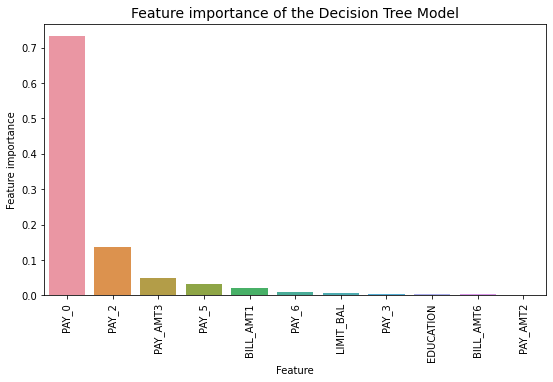

In [34]:
#Choosing the final Decision Tree Classification model and plotting the feature importance
model_1 = run_model (df=data_ccd, model=DecisionTreeClassifier(max_depth= 4),label_name='default payment next month')
plot_feature_importance(df=data_ccd, model=model_1)

The feature importance measures show that PAY_0 is the most important when using this Decision Tree model, this is followed by PAY_2 and PAY_AMT3.

### Gradient Boost Models

#### Running Gradient Booster models with different max depth values

In [36]:
#Setting different parameters of max_depth for the Gradient Booster Classifier
max_depth_values = [2,4,6,10,15]
#Initializing accuracy data
training_accuracy_data = []
test_accuracy_data = []
#Running the Gradient Booster regression tree models
for value in max_depth_values:
    print("For max_depth =", value)
    dat = run_model(df=data_ccd,model=GradientBoostingClassifier(random_state=1,max_depth= value),label_name='default payment next month')
    #Recording training set accuracy
    training_accuracy_data.append(dat[2])
    #Recording test accuracy
    test_accuracy_data.append(dat[3])
    print("\n")

For max_depth = 2
Accuracy scores for model: GradientBoostingClassifier(max_depth=2, random_state=1)
Training set score: 0.825
Test set score: 0.814


For max_depth = 4
Accuracy scores for model: GradientBoostingClassifier(max_depth=4, random_state=1)
Training set score: 0.833
Test set score: 0.817


For max_depth = 6
Accuracy scores for model: GradientBoostingClassifier(max_depth=6, random_state=1)
Training set score: 0.857
Test set score: 0.813


For max_depth = 10
Accuracy scores for model: GradientBoostingClassifier(max_depth=10, random_state=1)
Training set score: 0.940
Test set score: 0.808


For max_depth = 15
Accuracy scores for model: GradientBoostingClassifier(max_depth=15, random_state=1)
Training set score: 0.999
Test set score: 0.804




#### Plotting accuracy scores of the Gradient Boosted models

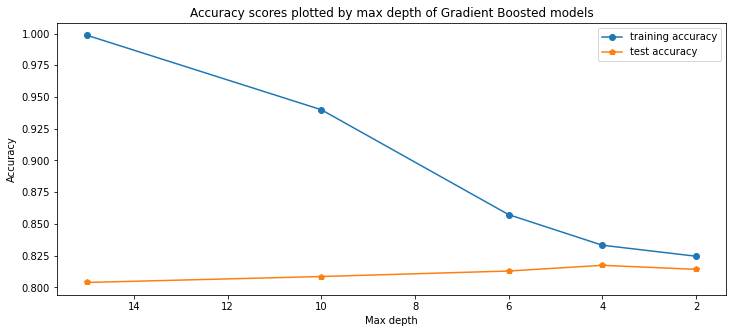

In [37]:
#Plotting accuracy scores of Decision Tree models by max depth values
plot_accuracy(title="Accuracy scores plotted by max depth of Gradient Boosted models",x_axis_name="Max depth",y_axis_name="Accuracy",param=max_depth_values,train_score=training_accuracy_data,test_score=test_accuracy_data)

Optimizing the Gradient Boosted Classifier model by playing around with max depth show that increasing the depth leads to overfitting (max_depth of 20 resulted to a training accuracy score of 1.000). Basing from the accuracy scores, we can choose a max depth of between 4 (test score = 0.817)  or 6 (test score = 0.813). For this case, we choose the model with a max depth of 4 - this led to an improvement of the scores (both training and test) comparing it with the model just using default parameters.

#### Plotting feature importance of Gradient Boosted Model with maximum_depth = 4

Accuracy scores for model: GradientBoostingClassifier(max_depth=4, random_state=1)
Training set score: 0.833
Test set score: 0.817


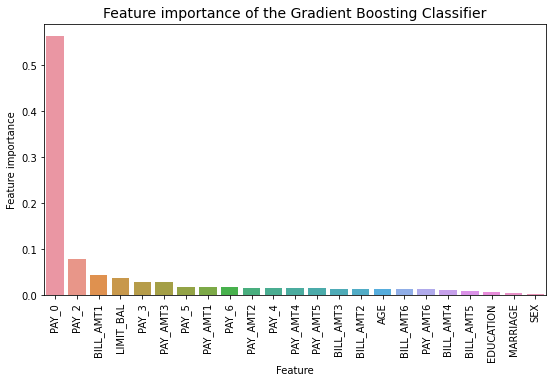

In [38]:
#Choosing the "final" Gradient Boosted Classification model and plotting the feature importance
model_2 = run_model (df=data_ccd, model=GradientBoostingClassifier(random_state=1,max_depth= 4),label_name='default payment next month')
plot_feature_importance(df=data_ccd, model=model_2,title='Feature importance of the Gradient Boosting Classifier')

Using the Gradient Boosted Classification model, we also see that PAY_0 is the most important feature followed by the PAY_2 - similar results from the Decision Tree model. However here, BILL_AMT1 is the third most important feature.

# Task 3 (9 points): 

Multiclass & binary classification $\to$ Drug consumption (quantified) Data Set

https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29

Data Set Information:

Database contains records for 1885 respondents. For each respondent 12 attributes are known: Personality measurements which include NEO-FFI-R (neuroticism, extraversion, openness to experience, agreeableness, and conscientiousness), BIS-11 (impulsivity), and ImpSS (sensation seeking), level of education, age, gender, country of residence and ethnicity. All input attributes are originally categorical and are quantified. After quantification values of all input features can be considered as real-valued. In addition, participants were questioned concerning their use of 18 legal and illegal drugs (alcohol, amphetamines, amyl nitrite, benzodiazepine, cannabis, chocolate, cocaine, caffeine, crack, ecstasy, heroin, ketamine, legal highs, LSD, methadone, mushrooms, nicotine and volatile substance abuse and one fictitious drug (Semeron) which was introduced to identify over-claimers. For each drug they have to select one of the answers: never used the drug, used it over a decade ago, or in the last decade, year, month, week, or day.

Database contains 18 classification problems. Each of independent label variables contains seven classes: "Never Used", "Used over a Decade Ago", "Used in Last Decade", "Used in Last Year", "Used in Last Month", "Used in Last Week", and "Used in Last Day".

* Fit two multiclass classification models to predict two selected features out of 18. Use numerical values to represent each class. Report accuracy with the default parameters of each model.
* Perform a simple manual optimization for one of the default parameters (at least 5 different values) for one of the previous models. Plot the new obtained accuracy as a function of the chosen parameter. 
* Fit one multiclass classification model for all the rest 16 features. Comment on the accuracy of predicting each feature, for all the seven classes. 
* Run one binary classification model for 3 features out of 18. Test the performance of the model by choosing as:
 - one class (class 0) the variable "Used in Last Decade" and the remaining variables for the other class (class 1).
 - one class (class 0) the variables "Used in Last Decade" and "Used in Last Year" and the remaining variables for the other class (class 1).
 - one class (class 0) the variables "Used in Last Decade", "Used in Last Year", "Used in Last Month" and the remaining variables for the other class (class 1).
 
 Comment your results, and point which selection of classes have better accuracy.

## Reading and loading data and creating the functions to be used to run models

In [39]:
#Reading and loading the data set
#importing zipfile, requests, io
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data'
data_3 = pd.read_csv(url, header=None)
#data_3.head(3)

In [40]:
#Renaming column names
data_3.columns = ['ID', 'Age','Gender','Education','Country','Ethnicity','Nscore','Escore','Oscore','Ascore','Cscore','Impulsive','SS','Alcohol','Amphetamine','Amyl','Benzos','Caffeine','Cannabis','Chocolate','Cocaine','Crack','Ecstacy','Heroin','Ketamine','LegalH','LSD','Meth','Mushrooms','Nicotine','Semeron','VSA']

In [41]:
#Selecting features data
features_columns = ['Age','Gender','Education','Country','Ethnicity','Nscore','Escore','Oscore','Ascore','Cscore','Impulsive','SS']
features_data = data_3[features_columns]

In [42]:
#Selecting drugs (label) data
drug_columns = ['Alcohol','Amphetamine','Amyl','Benzos','Caffeine','Cannabis','Chocolate','Cocaine','Crack','Ecstacy','Heroin','Ketamine','LegalH','LSD','Meth','Mushrooms','Nicotine','Semeron','VSA']
drug_data = data_3[drug_columns]

In [43]:
#Creating copy of drug data for reclassing drugs
drug_data_reclass = drug_data.copy(deep=True)
#Resetting drug classes as numeric values
for i in drug_columns:
    drug_data_reclass[i] = drug_data_reclass[i].map({'CL0': 0, 'CL1': 1, 'CL2': 2, 'CL3': 3, 'CL4': 4, 'CL5': 5, 'CL6': 6})

In [44]:
#Creating a function that runs the multiclass classification given a datamodel and label_name
def run_multiclass (model, label_name,classes):
    #Splitting data into train and test
    X_train, X_test, y_train, y_test = train_test_split(features_data, label_name, test_size = 0.2, random_state = 1)
    #Running the model using the training set
    base_model = model
    model_fit = base_model.fit(X_train.values, y_train)
    predictions = model_fit.predict(X_test.values)
    #Computing for accuracy scores
    training_score = base_model.score(X_train.values, y_train)
    test_score = base_model.score(X_test.values, y_test)
    #Creating a confusion matrix
    #cm = confusion_matrix(y_test, predictions)
    #Computing for f1 score
    f1_weighted = f1_score(y_test, predictions, average='weighted',zero_division=0)
    f1_none = f1_score(y_test, predictions, average=None, labels=list(range(classes)), zero_division=0)
    return model_fit, y_test, predictions, training_score, test_score, f1_weighted, f1_none

In [45]:
#Creating a function that fits a model and prints accuracy results with F1 score averaging = weighted
def fit_multiclass (model, label_name,classes):
    fitted = run_multiclass(model, label_name,classes)
    def print_scores():
        print("Accuracy scores for model:",model,"on predicting:",label_name.name)
        print("Training set score: {:.3f}".format(fitted[3]))
        print("Test set score: {:.3f}".format(fitted[4]))
        #print("\nConfusion matrix:",cm)
        print("F1-score (weighted): {:.3f} \n".format(fitted[5]))
    return print_scores()

## Fitting 2 multiclass classification model to predict use of 2 selected drugs

In [46]:
#Running 2 classification models for 2 selected label (drug of use: Ecstacy and Mushrooms)
selected_models = [LinearSVC(max_iter=2000),KNeighborsClassifier()]
selected_labels = ['Ecstacy', 'Mushrooms']

for labels in selected_labels:
    for models in selected_models:
        fit_multiclass(model=models, label_name= drug_data_reclass[labels],classes=7)

Accuracy scores for model: LinearSVC(max_iter=2000) on predicting: Ecstacy
Training set score: 0.560
Test set score: 0.565
F1-score (weighted): 0.456 

Accuracy scores for model: KNeighborsClassifier() on predicting: Ecstacy
Training set score: 0.633
Test set score: 0.515
F1-score (weighted): 0.439 

Accuracy scores for model: LinearSVC(max_iter=2000) on predicting: Mushrooms
Training set score: 0.563
Test set score: 0.520
F1-score (weighted): 0.420 

Accuracy scores for model: KNeighborsClassifier() on predicting: Mushrooms
Training set score: 0.646
Test set score: 0.509
F1-score (weighted): 0.455 



Here we see that predicting class of Ecstacy use with the LinearSVC model has slightly better results comparing both the test accuracy (0.565) and F1 scores (0.456).
For predicting class of Mushroom use with the KNeighbor Classifier has slightly better results with the F1 score(0.455) and training set score (0.646).

## Performing manual optimization of one default parameter of one of the models for 5 different values

In [47]:
#Setting different parameters of n_neighbors for the KNN classifier model
n_neighbor_values = [2,6,10,15,20]
labels = 'Mushrooms'
#Initializing accuracy data
training_accuracy_data = []
test_accuracy_data = []
f1_data = []
#Running the KNN classifier models
for value in n_neighbor_values:
    multi = run_multiclass(model=KNeighborsClassifier(n_neighbors=value), label_name=drug_data_reclass[labels],classes=7)
    #Recording training set accuracy
    training_accuracy_data.append(multi[3])
    #Recording test accuracy
    test_accuracy_data.append(multi[4])
    #Recording F1 score
    f1_data.append(multi[5])

In [48]:
#Plotting accuracy scores
def plot_scores(title,x_axis_name,y_axis_name,param):
    plt.figure(figsize=(12, 6))
    plt.plot(param, training_accuracy_data, label="training accuracy",marker='o')
    plt.plot(param, test_accuracy_data, label="test accuracy",marker='p')
    plt.plot(param, f1_data, label="F1 score",marker='D')
    plt.title(title)
    plt.ylabel(y_axis_name)
    plt.xlabel(x_axis_name)
    plt.legend()

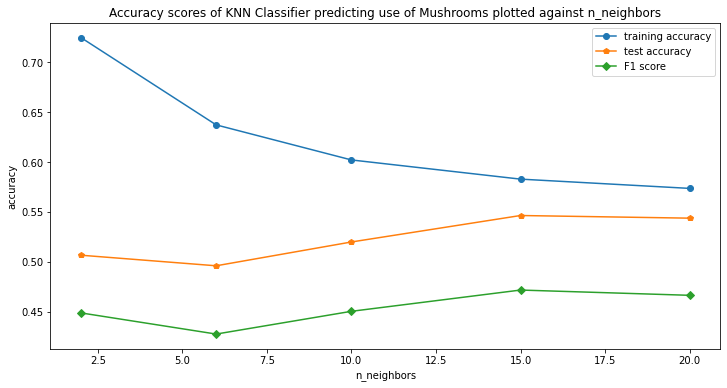

In [49]:
plot_scores(title="Accuracy scores of KNN Classifier predicting use of Mushrooms plotted against n_neighbors",
            x_axis_name='n_neighbors',y_axis_name='accuracy',param=n_neighbor_values)

In [50]:
fit_multiclass(model=KNeighborsClassifier(n_neighbors=15), label_name=drug_data_reclass[labels],classes=7)

Accuracy scores for model: KNeighborsClassifier(n_neighbors=15) on predicting: Mushrooms
Training set score: 0.583
Test set score: 0.546
F1-score (weighted): 0.472 



Here we see that manual fine tuning the parameter n_neighbors for the KNeighbor classifier in predicting the class of Mushroom use. Setting the n-neighbors to 15, the test accuracy improved to 0.546 and the F1 score improved to 0.472.

## Fitting a multiclass classification model for all the rest of 16 features

In [51]:
#Creating a function that fits a model and prints accuracy results with F1 score averaging = None
def fit_multiclass_f1_none (model, label_name,classes):
    fitted = run_multiclass(model, label_name,classes)
    def print_scores():
        print("Accuracy scores for model:",model,"on predicting:",label_name.name)
        print("Training set score: {:.3f}".format(fitted[3]))
        print("Test set score: {:.3f}".format(fitted[4]))
        #print("\nConfusion matrix:",cm)
        print("F1-score (weighted): {:.3f}\n".format(fitted[5]))
    return print_scores(), fitted[6]

In [52]:
#Selecting all data
selected_labels = ['Alcohol','Amphetamine','Amyl','Benzos','Caffeine','Cannabis','Chocolate','Cocaine','Crack','Heroin','Ketamine','LegalH','LSD','Meth','Nicotine','VSA']
#Initializing f1 score tables for each class
f1_score_table = []
#Running the classification models for the rest of the labels
for labels in selected_labels:
    all_models = fit_multiclass_f1_none(model=KNeighborsClassifier(n_neighbors=15), label_name= drug_data_reclass[labels],classes=7)
    f1_score_table.append(all_models[1].tolist())

Accuracy scores for model: KNeighborsClassifier(n_neighbors=15) on predicting: Alcohol
Training set score: 0.438
Test set score: 0.390
F1-score (weighted): 0.318

Accuracy scores for model: KNeighborsClassifier(n_neighbors=15) on predicting: Amphetamine
Training set score: 0.562
Test set score: 0.496
F1-score (weighted): 0.406

Accuracy scores for model: KNeighborsClassifier(n_neighbors=15) on predicting: Amyl
Training set score: 0.712
Test set score: 0.703
F1-score (weighted): 0.601

Accuracy scores for model: KNeighborsClassifier(n_neighbors=15) on predicting: Benzos
Training set score: 0.564
Test set score: 0.509
F1-score (weighted): 0.385

Accuracy scores for model: KNeighborsClassifier(n_neighbors=15) on predicting: Caffeine
Training set score: 0.739
Test set score: 0.716
F1-score (weighted): 0.598

Accuracy scores for model: KNeighborsClassifier(n_neighbors=15) on predicting: Cannabis
Training set score: 0.440
Test set score: 0.419
F1-score (weighted): 0.353

Accuracy scores for 

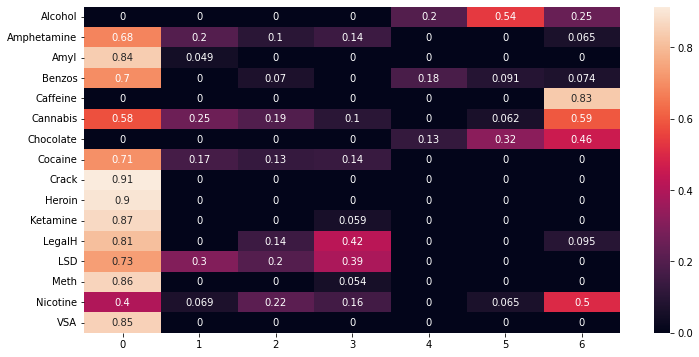

In [53]:
#Plotting f1 scores as a heatmap
plt.figure(figsize = (12,6))
data = np.asarray(f1_score_table).reshape(16,7)
data = pd.DataFrame(data, index=selected_labels)
plot = sns.heatmap(data, annot= True)
plt.show()

Based on the F1-score heatmap, the KNeighbor model is able to accurately classify people who have never used (CL0) the particular drug for most of the drugs. For caffeine, the model is able to classify people who have taken it the previous day (i.e. assumingly daily coffee drinkers). Interestingly for Cannabis, the model is also able to somewhat classify people who either have never used it or those who use have used it the previous day.

### Running a binary classification model for 3 labels out of 18

#### Resetting labels to binary

In [54]:
#Creating copy of drug data for reclassing drugs as binary
drug_data_bin_1 = drug_data.copy(deep=True)
drug_data_bin_2 = drug_data.copy(deep=True)
drug_data_bin_3 = drug_data.copy(deep=True)
#Resetting drug classes as binary (numeric) values based on one class (class 0) the variable "Used in Last Decade" and the remaining variables for the other class (class 1)
for i in drug_columns:
    drug_data_bin_1[i] = drug_data_bin_1[i].map({'CL0': 1, 'CL1': 1, 'CL2': 0, 'CL3': 1, 'CL4': 1, 'CL5': 1, 'CL6': 1})
    drug_data_bin_2[i] = drug_data_bin_2[i].map({'CL0': 1, 'CL1': 1, 'CL2': 0, 'CL3': 0, 'CL4': 1, 'CL5': 1, 'CL6': 1})
    drug_data_bin_3[i] = drug_data_bin_3[i].map({'CL0': 1, 'CL1': 1, 'CL2': 0, 'CL3': 0, 'CL4': 0, 'CL5': 1, 'CL6': 1})

#### Running a KNeighbor models using the new binaru classes Class 0 to classify use of 3 selected drugs

In [55]:
def run_binary_reclassified(data1, data2, data3,class_labels):
    #Initializing f1 score tables for each class
    f1_score_table_last = []
    #Choosing drugs as labels
    drug_labels = ['Cannabis','Cocaine','Meth']
    #Setting dataset with different Class 0 variables
    selected_data = {'Last Decade' : data1,
                     'Last Decade and Last Year' : data2, 
                     'Last Decade, Last Year and Last Month' : data3}
    #Running the classification models for the rest of the labels
    for data in selected_data.keys():
        print("\033[1mFor new Class 0 variable(s): Used in",data,"\033[0m")
        for labels in drug_labels:
            models = fit_multiclass_f1_none(model=KNeighborsClassifier(n_neighbors=15), label_name= selected_data[data][labels],classes=2)
            f1_score_table_last.append(models[1].tolist())
    
    print("\033[1mF1-scores per class of the selected drugs as heatmaps\033[0m")
    plot_heatmap(f1_score_table_last,drug_labels,class_labels)

In [56]:
def plot_heatmap(data,drug_labels,class_labels):
    #Reshapping f1 score table
    data1 = np.asarray(data).reshape (3,3,2)
    #Plotting f1 scores as a heatmap
    fig, axs = plt.subplots(ncols=3,figsize=(19, 2))
    sns.heatmap(data1[0], annot= True, yticklabels=drug_labels, ax=axs[0]).set_title(class_labels[0])
    sns.heatmap(data1[1], annot= True, yticklabels=drug_labels, ax=axs[1]).set_title(class_labels[1])
    sns.heatmap(data1[2], annot= True, yticklabels=drug_labels, ax=axs[2]).set_title(class_labels[2])

For new Class 0 variable(s): Used in Last Decade 
Accuracy scores for model: KNeighborsClassifier(n_neighbors=15) on predicting: Cannabis
Training set score: 0.853
Test set score: 0.881
F1-score (weighted): 0.830

Accuracy scores for model: KNeighborsClassifier(n_neighbors=15) on predicting: Cocaine
Training set score: 0.849
Test set score: 0.889
F1-score (weighted): 0.836

Accuracy scores for model: KNeighborsClassifier(n_neighbors=15) on predicting: Meth
Training set score: 0.945
Test set score: 0.963
F1-score (weighted): 0.945

For new Class 0 variable(s): Used in Last Decade and Last Year 
Accuracy scores for model: KNeighborsClassifier(n_neighbors=15) on predicting: Cannabis
Training set score: 0.749
Test set score: 0.767
F1-score (weighted): 0.699

Accuracy scores for model: KNeighborsClassifier(n_neighbors=15) on predicting: Cocaine
Training set score: 0.750
Test set score: 0.735
F1-score (weighted): 0.685

Accuracy scores for model: KNeighborsClassifier(n_neighbors=15) on predi

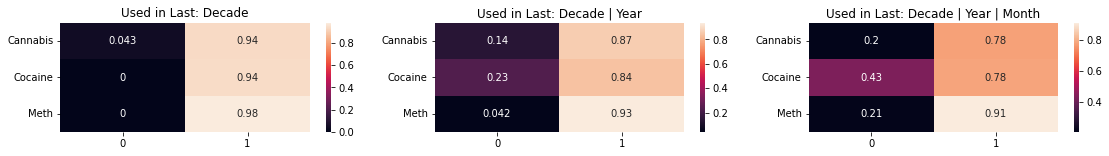

In [57]:
#Setting plot labels
class_labels = ['Used in Last: Decade','Used in Last: Decade | Year','Used in Last: Decade | Year | Month']
#running the models and plotting scores
run_binary_reclassified(drug_data_bin_1,drug_data_bin_2,drug_data_bin_3,class_labels=class_labels)

Re-classifiying the classes into binary category as Used in Last Decade = 0 and the rest = 1 did not really improve the performance of the model in classifying people who have used the 3 drugs in the last decade, when looking at the F1-scores of both classes. However, the model was able to classify all the rest. The second scenario where Class 0 was set as Used in Last Decade or in the Last Year, the model also did not perform that well in classifying Class 0. Of the three, the third model performed just slightly better in balancing the F1-scores of the three drugs for both classes.

With that said, it still would be worth to consider other ways of re-classifying the classes. I am keen to explore grouping together Never Used, Used Last in over a decade and Used in the Last Decade as Class 0, i.e. I want to classify people who have never used or who have stopped using drugs for a long time. I'm doing an extra exploration of this below.

#### Extra exploration: Classifying People who never used drugs or who have stopped using drugs for a long time

In [58]:
#Creating copy of drug data for reclassing drugs as binary
drug_data_extra_1 = drug_data.copy(deep=True)
drug_data_extra_2 = drug_data.copy(deep=True)
drug_data_extra_3 = drug_data.copy(deep=True)
#Resetting drug classes as binary (numeric) values based on one class (class 0) the variable "Used in Last Decade" and the remaining variables for the other class (class 1)
for i in drug_columns:
    drug_data_extra_1[i] = drug_data_extra_1[i].map({'CL0': 0, 'CL1': 1, 'CL2': 1, 'CL3': 1, 'CL4': 1, 'CL5': 1, 'CL6': 1})
    drug_data_extra_2[i] = drug_data_extra_2[i].map({'CL0': 0, 'CL1': 0, 'CL2': 1, 'CL3': 1, 'CL4': 1, 'CL5': 1, 'CL6': 1})
    drug_data_extra_3[i] = drug_data_extra_3[i].map({'CL0': 0, 'CL1': 0, 'CL2': 1, 'CL3': 0, 'CL4': 1, 'CL5': 1, 'CL6': 1})

For new Class 0 variable(s): Used in Last Decade 
Accuracy scores for model: KNeighborsClassifier(n_neighbors=15) on predicting: Cannabis
Training set score: 0.821
Test set score: 0.817
F1-score (weighted): 0.810

Accuracy scores for model: KNeighborsClassifier(n_neighbors=15) on predicting: Cocaine
Training set score: 0.712
Test set score: 0.674
F1-score (weighted): 0.671

Accuracy scores for model: KNeighborsClassifier(n_neighbors=15) on predicting: Meth
Training set score: 0.795
Test set score: 0.793
F1-score (weighted): 0.768

For new Class 0 variable(s): Used in Last Decade and Last Year 
Accuracy scores for model: KNeighborsClassifier(n_neighbors=15) on predicting: Cannabis
Training set score: 0.814
Test set score: 0.812
F1-score (weighted): 0.814

Accuracy scores for model: KNeighborsClassifier(n_neighbors=15) on predicting: Cocaine
Training set score: 0.729
Test set score: 0.703
F1-score (weighted): 0.700

Accuracy scores for model: KNeighborsClassifier(n_neighbors=15) on predi

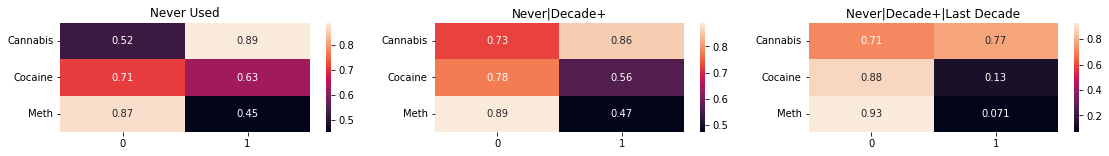

In [59]:
#Setting plot labels
class_labels = ['Never Used','Never|Decade+','Never|Decade+|Last Decade']
#running the models and plotting scores
run_binary_reclassified(drug_data_extra_1,drug_data_extra_2,drug_data_extra_3,class_labels=class_labels)

As we can see, compared with the previous scenarios, all three groupings have performed better in classifying people who have either never used drugs or who have stopped using for a long time. Looking at the F1-scores, the second model has particularly performed well in balancing being able to classify both classes correctly.